In [1]:
from typing import Tuple
import pandas as pd
from scipy.stats import pearsonr
from tqdm.notebook import tqdm
import sys
sys.path.append('..')
from evaluation.generated_dataset import GeneratedDataset, load_all_from_config
from evaluation.novelty import NoveltyFilter, filter_by_unique_structure

/home/kna/.cache/pypoetry/virtualenvs/wyckofftransformer-FeCwefly-py3.12/lib/python3.12/site-packages/matminer/utils/data.py:326: UserWarning: MagpieData(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source will be replaced by the average of that value
                    over the available elements.
                    This avoids NaNs after featurization that are often replaced by
                    dataset-dependent averages.
  warnings.warn(f"{self.__class__.__name__}(impute_nan=False):\n" + IMPUTE_NAN_WARNING)


In [2]:
dft_datasets = {
  #  "WyFormerDirect": ("WyckoffTransformer", "DFT"),
    "WyFormerCrySPR": ("WyckoffTransformer", "CrySPR", "CHGNet_fix", "DFT"),
    "WyFormerDiffCSP++": ("WyckoffTransformer", "DiffCSP++", "DFT"),
    "DiffCSP": ("DiffCSP", "DFT"),
  #  "CrystalFormer WRONG": ("CrystalFormer", "DFT"),
    "DiffCSP++": ("DiffCSP++", "DFT"),
  #  "FlowMM": ("FlowMM", "DFT")
}

source_datasets = {name: t[:-1] for name, t in dft_datasets.items()}

In [3]:
chgnet_datasets = {
    "WyFormerDirect": ("WyckoffTransformer", "CrySPR", "CHGNet_fix_release"),
    "WyFormerCrySPR": ("WyckoffTransformer", "CrySPR", "CHGNet_fix_release"),
    "WyFormerDiffCSP++": ("WyckoffTransformer", "DiffCSP++", "CHGNet_fix"),
    "DiffCSP": ("DiffCSP", "CHGNet_fix"),
    "CrystalFormer WRONG": ("CrystalFormer", "CHGNet_fix_release"),
    "DiffCSP++": ("DiffCSP++", "CHGNet_fix_release"),
    "FlowMM": ("FlowMM", "CHGNet_fix")
}

In [4]:
chgnet_data = load_all_from_config(datasets=list(chgnet_datasets.values()) + [('WyckoffTransformer', 'CrySPR', 'CHGNet_fix')])

In [5]:
all_datasets = load_all_from_config(
    datasets=list(dft_datasets.values()) + list(source_datasets.values()) + \
        [("split", "train"), ("split", "val"), ("split", "test")],
    dataset_name="mp_20")

In [6]:
#wycryst_transformations = ('WyCryst', 'CrySPR', 'CHGNet_fix')
#source_datasets["WyCryst"] = wycryst_transformations
#all_datasets[wycryst_transformations] = GeneratedDataset.from_cache(wycryst_transformations, "mp_20_biternary")
#dft_datasets["WyCryst"] = tuple(list(wycryst_transformations) + ["DFT"])
#all_datasets[dft_datasets["WyCryst"]] = GeneratedDataset.from_cache(dft_datasets["WyCryst"], "mp_20_biternary")

In [7]:
excluded_categories = frozenset(["radioactive", "rare_earth_metal", "noble_gas"])
from pymatgen.core import Structure
def check_composition(structure: Structure) -> bool:
    for category in excluded_categories:
        if structure.composition.contains_element_type(category):
            return False
    return True

In [8]:
novelty_reference = pd.concat([
    all_datasets[('split', 'train')].data,
    all_datasets[('split', 'val')].data], axis=0, verify_integrity=True)
novelty_filter = NoveltyFilter(novelty_reference)

In [9]:
import evaluation.statistical_evaluator
test_evaluator = evaluation.statistical_evaluator.StatisticalEvaluator(all_datasets[('split', 'test')].data)

In [10]:
import evaluation.novelty
train_w_template_set = frozenset(novelty_reference.apply(evaluation.novelty.record_to_anonymous_fingerprint, axis=1))
train_strict_AFLOW_set = frozenset(novelty_reference.apply(evaluation.novelty.record_to_strict_AFLOW_fingerprint, axis=1))
train_relaxed_AFLOW_set = frozenset(novelty_reference.apply(evaluation.novelty.record_to_relaxed_AFLOW_fingerprint, axis=1))

In [11]:
def is_sg_preserved(relaxed_sg, transformations: Tuple[str]) -> pd.Series:
    source_sg = all_datasets[(transformations[0],)].data.spacegroup_number
    return relaxed_sg == source_sg.reindex_like(relaxed_sg)

In [12]:
mp_20 = pd.concat([
    all_datasets[('split', 'train')].data,
    all_datasets[('split', 'test')].data,
    all_datasets[('split', 'val')].data], axis=0, verify_integrity=True)
(mp_20.spacegroup_number == 1).mean()
mp_20.smact_validity.mean()

0.9057020937893829

In [13]:
from collections import Counter
from operator import itemgetter
from itertools import chain
element_counts = Counter(chain(*mp_20.elements))

In [14]:
represented_elements=frozenset(map(itemgetter(0), element_counts.most_common(30)))

In [15]:
def check_represented_composition(structure: Structure) -> bool:
    for element in structure.composition:
        if element not in represented_elements:
            return False
    return True

In [16]:
top_10_groups = frozenset(mp_20.spacegroup_number.value_counts().iloc[:10].index)
n_elements_dist = {}

Validity
1. Vanilla; Valid records: 2866 / 9648 = 29.71%
2. Naive; Valid records: 9492 / 9804 = 96.82%
3. Site Symmetry; Valid records: 8955 / 9709 = 92.23%

In [67]:
table = pd.DataFrame(
    index=dft_datasets.keys(), columns=[
        "DFT dataset size",
        "Source Novelty (%)",
        "In-DFT Novelty (%)",
        "S.U.N. (%)",
        "P1 in source (%)",
        "S.S.U.N. (%)"])
table.index.name = "Method"
E_hull_threshold = 0.08
for name, transformations in tqdm(dft_datasets.items()):
    dataset = all_datasets[transformations]
    table.loc[name, "DFT dataset size"] = len(dataset.data)
    source_dataset = all_datasets[transformations[:-1]]
    chgnet_dataset = chgnet_data[chgnet_datasets[name]]

    unique = filter_by_unique_structure(dataset.data)
    novel = novelty_filter.get_novel(unique)
    table.loc[name, "In-DFT Novelty (%)"] = 100 * len(novel) / len(unique)
    source_novel = novelty_filter.get_novel(source_dataset.data)
    source_novelty = 100 * len(source_novel) / len(source_dataset.data)
    table.loc[name, "Source Novelty (%)"] = len(novel) / len(unique) * source_novelty
    table.loc[name, "P1 in source (%)"] = 100 * (source_novel.group == 1).mean()
    #source_novel_symmetric = (source_novel.group != 1).sum() / len(source_dataset.data)
    #table["Source Novel !P1 (%)"] = 100 * source_novel_symmetric
    has_ehull = dataset.data.corrected_e_hull.notna()
    is_sun = (novel.corrected_e_hull <= E_hull_threshold) # & (novel.elements.apply(lambda x: len(frozenset(x))) >= 2)
    table.loc[name, "S.U.N. (%)"] = source_novelty * is_sun.sum() / has_ehull.sum()
    table.loc[name, "total_sun"] = is_sun.sum().astype(int)
    table.loc[name, "S.S.U.N. (%)"] = source_novelty * (is_sun & (novel.group != 1)).sum() / has_ehull.sum()
    table.loc[name, "total_ssun"] = (is_sun & (novel.group != 1)).sum().astype(int)
    table.loc[name, "P1 in stable (%)"] = 100 * (novel[is_sun].group == 1).mean()

    chgnet_unique = filter_by_unique_structure(chgnet_dataset.data)
    chgnet_novel = novelty_filter.get_novel(chgnet_unique)
    chgnet_is_sun = (chgnet_novel.corrected_chgnet_ehull < E_hull_threshold)
    #table.loc[name, "CHGNet dataset size"] = chgnet_dataset.data.corrected_chgnet_ehull.notna().sum()
    table.loc[name, "S.U.N. (CHGNet) (%)"] =  100 * chgnet_is_sun.sum() / chgnet_dataset.data.corrected_chgnet_ehull.notna().sum()
    table.loc[name, "S.S.U.N. (CHGNet) (%)"] = 100 * (chgnet_is_sun & (chgnet_novel.group != 1)).sum() / chgnet_dataset.data.corrected_chgnet_ehull.notna().sum()
    
    chgnet_dft_available = chgnet_dataset.data.reindex(dataset.data.index)
    table.loc[name, "r DFT CHGNet"] = \
        pearsonr((chgnet_dft_available.corrected_chgnet_ehull < E_hull_threshold).astype(float),
                 (dataset.data.corrected_e_hull < E_hull_threshold).astype(float)).correlation
table

  0%|          | 0/4 [00:00<?, ?it/s]

,DFT dataset size,Source Novelty (%),In-DFT Novelty (%),S.U.N. (%),P1 in source (%),S.S.U.N. (%),total_sun,total_ssun,P1 in stable (%),S.U.N. (CHGNet) (%),S.S.U.N. (CHGNet) (%),r DFT CHGNet
Method,,,,,,,,,,,,
WyFormerCrySPR,96,90.0,100.0,7.5,1.555556,7.5,8.0,8.0,0.000000,39.239239,38.238238,0.334740
WyFormerDiffCSP++,95,88.557895,98.947368,14.131579,1.564246,14.131579,15.0,15.0,0.000000,36.700000,36.000000,0.437595
DiffCSP,82,88.714756,98.780488,20.809634,31.566641,13.142927,19.0,12.0,36.842105,57.400000,40.600000,0.360729
DiffCSP++,94,88.95,100.0,8.516489,1.843732,8.516489,9.0,9.0,0.000000,41.400000,40.800000,0.321342


In [68]:
def prettify(table):
    return table.style.format({
    "S.U.N. (%)": "{:.1f}",
    "S.S.U.N. (%)": "{:.1f}",
    "S.U.N. (CHGNet) (%)": "{:.1f}",
    "S.S.U.N. (CHGNet) (%)": "{:.1f}",
    "r DFT CHGNet": "{:.2f}",
}).highlight_max(props="font-weight: bold", axis=0, subset=["S.U.N. (%)", "S.S.U.N. (%)", "S.U.N. (CHGNet) (%)", "S.S.U.N. (CHGNet) (%)"])

In [69]:
selected_table = table.loc[:, ["DFT dataset size", "S.U.N. (%)", "S.S.U.N. (%)", "r DFT CHGNet", "S.U.N. (CHGNet) (%)", "S.S.U.N. (CHGNet) (%)"]]

In [70]:
pretty_table = prettify(selected_table)
pretty_table.to_latex("tables/dft_vs_chgnet.tex", siunitx=True, convert_css=True)
pretty_table

,DFT dataset size,S.U.N. (%),S.S.U.N. (%),r DFT CHGNet,S.U.N. (CHGNet) (%),S.S.U.N. (CHGNet) (%)
Method,,,,,,
WyFormerCrySPR,96,7.5,7.5,0.33,39.2,38.2
WyFormerDiffCSP++,95,14.1,14.1,0.44,36.7,36.0
DiffCSP,82,20.8,13.1,0.36,57.4,40.6
DiffCSP++,94,8.5,8.5,0.32,41.4,40.8


In [71]:
all_datasets[('split', 'test')].data.apply(evaluation.novelty.record_to_anonymous_fingerprint, axis=1).isin(train_w_template_set).mean()

0.9713685606898077

In [72]:
all_datasets[('split', 'test')].data.apply(evaluation.novelty.record_to_strict_AFLOW_fingerprint, axis=1).isin(train_strict_AFLOW_set).mean()

0.9328985186822906

In [73]:
CF_CG = GeneratedDataset.from_cache(("CrystalFormer", "CHGNet_fix_release"))

In [86]:
def get_observation(name, column="total_ssun"):
    all_observations = np.zeros(table.loc[name, "DFT dataset size"])
    all_observations[:int(table.at[name, column])] = table.loc[name, "Source Novelty (%)"]/100
    print(all_observations.mean())
    return all_observations

In [88]:
ttest_ind(get_observation("WyFormerDiffCSP++", "total_sun"), get_observation("DiffCSP", "total_sun"))

0.13982825484764544
0.2055585812016657


TtestResult(statistic=-1.247125872330728, pvalue=0.2140178215673167, df=175.0)

In [89]:
ttest_ind(get_observation("DiffCSP++", "total_sun"), get_observation("DiffCSP", "total_sun"))

0.08516489361702129
0.2055585812016657


TtestResult(statistic=-2.482155242556018, pvalue=0.014007462431079434, df=174.0)

In [81]:
ttest_ind(get_observation("WyFormerDiffCSP++"), get_observation("DiffCSP"))

0.13982825484764544
0.12982647233789413


TtestResult(statistic=0.20707210907430382, pvalue=0.8361942926057152, df=175.0)

In [82]:
ttest_ind(get_observation("WyFormerDiffCSP++"), get_observation("DiffCSP++"))

0.13982825484764544
0.08516489361702129


TtestResult(statistic=1.2709073832738933, pvalue=0.20534030841538564, df=187.0)

In [84]:
ttest_ind(get_observation("WyFormerDiffCSP++"), get_observation("WyFormerCrySPR"))

0.13982825484764544
0.075


TtestResult(statistic=1.5470765477410633, pvalue=0.12351759062236797, df=189.0)

In [50]:
get_observation("DiffCSP++")

0.08516489361702129


In [ ]:
import numpy as np
a = np.zeros(95)
a[:14] = 1
b = np.zeros(82)
b[:13] = 1

In [34]:
ttest_ind(a, b)

TtestResult(statistic=-0.20492461993117714, pvalue=0.8378691749121991, df=175.0)

In [ ]:
pearsonr(is_stable_CHG.astype(float), is_stable_DFT.astype(float))

PearsonRResult(statistic=0.37903646651905626, pvalue=0.0009432999586367356)

/tmp/ipykernel_2813233/4049628493.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(CHG.corrected_chgnet_ehull, all_datasets[('CrystalFormer', 'DFT')].data.corrected_e_hull, cmap='coolwarm')


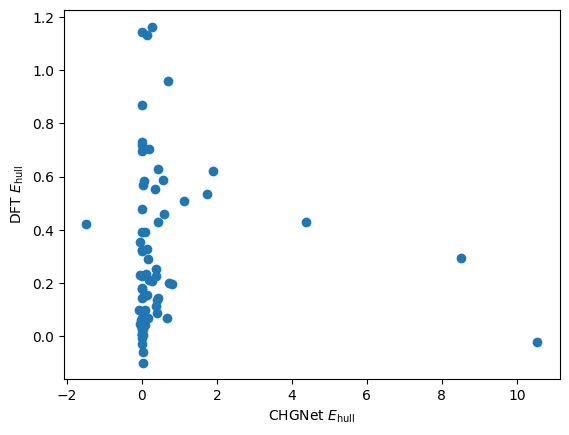

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(CHG.corrected_chgnet_ehull, all_datasets[('CrystalFormer', 'DFT')].data.corrected_e_hull, cmap='coolwarm')
ax.set_xlabel("CHGNet $E_\\text{hull}$")
ax.set_ylabel("DFT $E_\\text{hull}$");

In [ ]:
all_datasets[('CrystalFormer',)].data.columns

Index(['structure', 'density', 'site_symmetries', 'elements', 'multiplicity',
       'wyckoff_letters', 'sites_enumeration', 'dof', 'spacegroup_number',
       'sites_enumeration_augmented', 'composition', 'fingerprint', 'group',
       'sites', 'species', 'numIons', 'cdvae_crystal', 'structural_validity',
       'smact_validity', 'naive_validity', 'cdvae_e'],
      dtype='object')

In [ ]:
all_datasets[('CrystalFormer', 'DFT')].data.naive_validity.mean()

0.863013698630137

In [ ]:
stable = all_datasets[('CrystalFormer', 'DFT')].data.corrected_e_hull < E_hull_threshold

In [ ]:
all_datasets[('CrystalFormer', 'DFT')].data[stable].naive_validity

true_index
2       True
12      True
13      True
14      True
15      True
18      True
19      True
23      True
34      True
58      True
61      True
63      True
67      True
68      True
71      True
72      True
81      True
103     True
107     True
110    False
113     True
121     True
145     True
Name: naive_validity, dtype: bool

In [ ]:
stable.sum

23